In [90]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import sqlite3
import lifelines
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

conn = sqlite3.connect("../data/sample_20210509.sqlite")

# funnel stuff?

In [38]:
df = pd.read_sql_query(f"""
    select
        level,
        count(distinct name) as n
    from levels
    group by 1
    order by 1
""", conn)
df

,level,n
0,2,970
1,3,960
2,4,950
3,5,940
4,6,930
...,...,...
194,196,123
195,197,122
196,198,120
197,199,119


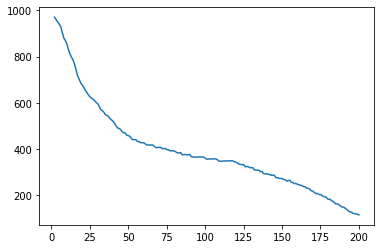

In [41]:
plt.plot(df.level, df.n)

# Survival stuff for level 120

In [3]:
level = 120
df = pd.read_sql_query(f"""
    with recent as (
        select 
            name,
            max(level) as level,
            min(timestamp) as start_ts,
            max(timestamp) as end_ts
        from levels
        where level <= {level}
        group by 1
    )
    select
        name,
        level,
        iif(level < {level}, julianday("2021-05-09"), julianday(end_ts)) - julianday(start_ts) as duration,
        level = {level} as observed
    from recent
""", conn)
df

,name,level,duration,observed
0,0100,8,789.443472,0
1,0men,99,513.571806,0
2,12PM,48,51.246887,0
3,1stTimeMaple,10,1768.058241,0
4,20XX,120,37.023866,1
...,...,...,...,...
985,yhwach,15,1074.440903,0
986,zImBaby,7,1959.207627,0
987,zenq,15,406.435961,0
988,zzaapp,23,31.685313,0


In [11]:
df[df.observed == 1].describe()

,level,duration,observed
count,345.0,345.000000,345.0
mean,120.0,107.044146,1.0
std,0.0,161.190462,0.0
min,120.0,4.698542,1.0
25%,120.0,29.773461,1.0
50%,120.0,53.694931,1.0
75%,120.0,100.279676,1.0
max,120.0,1159.546713,1.0


Text(0.5, 0, 'timescale (days)')

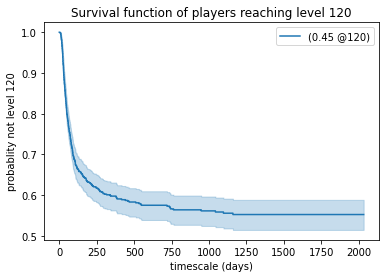

In [152]:
kmf = KaplanMeierFitter()
kmf.fit(df.duration, event_observed=df.observed)

kmf.plot_survival_function(label=f"({(1-kmf.survival_function_.KM_estimate.iloc[-1]):.2f} @120)")
plt.title(f"Survival function of players reaching level {level}");
plt.ylabel(f"probablity not level {level}")
plt.xlabel("timescale (days)")

In [147]:
kmf.percentile(0.9)

29.43960648123175

In [35]:
1 - kmf.survival_function_

,KM_estimate
timeline,
0.000000,0.000000
1.586586,0.000000
1.898692,0.000000
2.748160,0.000000
3.511088,0.000000
...,...
2015.242535,0.392984
2018.220035,0.392984
2019.826308,0.392984


Text(0.5, 0, 'timescale (days)')

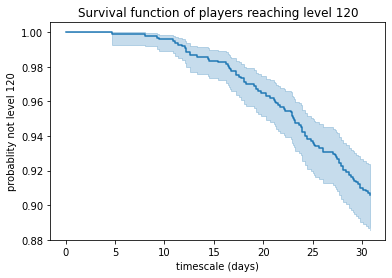

In [22]:
kmf = KaplanMeierFitter()
kmf.fit(df.duration, event_observed=df.observed)

kmf.plot_survival_function(iloc=slice(0,120), legend=False)
plt.title(f"Survival function of players reaching level {level}");
plt.ylabel(f"probablity not level {level}")
plt.xlabel("timescale (days)")

In [28]:
(df[df.observed == 1].count() / df.count()).observed

0.3484848484848485

# by class

In [47]:
pd.read_sql_query(f"""select * from ranking limit 5""", conn)

,index,timestamp,category,rank,name,job,specialization,mastery,level
0,0,2021-05-09T07:29:05.999614,all,1,Unlucky,magician,cleric,bishop,200
1,1,2021-05-09T07:29:05.999614,all,2,Babo,thief,assassin,night lord,200
2,2,2021-05-09T07:29:05.999614,all,3,Nude,thief,assassin,night lord,200
3,3,2021-05-09T07:29:05.999614,all,4,JayChou,magician,cleric,bishop,200
4,4,2021-05-09T07:29:05.999614,all,5,Zeretius,bowman,hunter,bowmaster,200


In [165]:
df = pd.read_sql_query(f"""
    with job as (
        select name, job
        from ranking
    )
    select
        name,
        level,
        job
    from levels
    left join job
    using (name)
""", conn)
df

,name,level,job
0,Unlucky,200,magician
1,Unlucky,199,magician
2,Unlucky,198,magician
3,Unlucky,197,magician
4,Unlucky,196,magician
...,...,...,...
78378,Lawkes,2,beginner
78379,Troyy,2,beginner
78380,Liridas,2,beginner
78381,Footwear,2,beginner


<AxesSubplot:xlabel='level'>

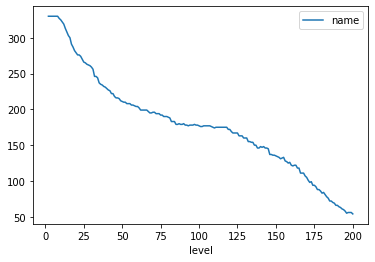

In [166]:
df[df.job == "magician"].groupby("level").count().reset_index().plot("level", "name")

Text(0, 0.5, 'player count')

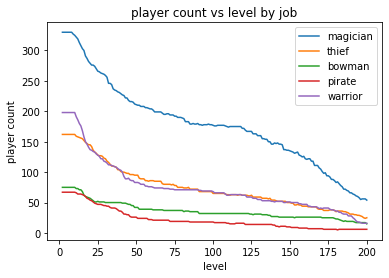

In [167]:
jobs = df[df.job != "beginner"].job.unique()
for job in jobs:
    x = df[df.job == job].groupby("level").count().reset_index().sort_values("level")
    plt.plot(x.level, x.name, label=job)
plt.legend()
plt.title("player count vs level by job")
plt.xlabel("level")
plt.ylabel("player count")

Text(0, 0.5, 'fraction of players in job')

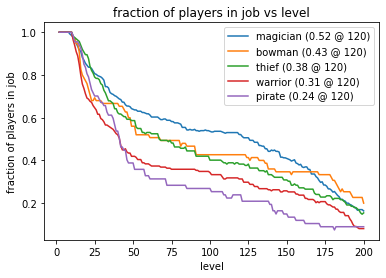

In [168]:
frac = []
# jobs = df[df.job != "beginner"].job.unique()
jobs = ["magician", "bowman", "thief", "warrior", "pirate"]
for job in jobs:
    x = df[df.job == job].groupby("level").count().reset_index().sort_values("level")
    f120 = x[x.level == 120].name.values[0]/x.name.max()
    plt.plot(x.level, x.name/x.name.max(), label=f"{job} ({f120:.2f} @ 120)")
    frac.append(dict(job=job, n=x.name.max(), frac=f120))
plt.legend()
plt.title("fraction of players in job vs level")
plt.xlabel("level")
plt.ylabel("fraction of players in job")

In [118]:
frac

[{'job': 'magician', 'n': 330, 'frac': 0.5212121212121212},
 {'job': 'thief', 'n': 162, 'frac': 0.38271604938271603},
 {'job': 'bowman', 'n': 75, 'frac': 0.4266666666666667},
 {'job': 'pirate', 'n': 67, 'frac': 0.23880597014925373},
 {'job': 'warrior', 'n': 198, 'frac': 0.31313131313131315}]

In [120]:
pd.DataFrame(frac)

,job,n,frac
0,magician,330,0.521212
1,thief,162,0.382716
2,bowman,75,0.426667
3,pirate,67,0.238806
4,warrior,198,0.313131


In [169]:
level = 120
df = pd.read_sql_query(f"""
    with recent as (
        select 
            name,
            max(level) as level,
            min(timestamp) as start_ts,
            max(timestamp) as end_ts
        from levels
        where level <= {level}
        group by 1
    ),
    job as (
        select name, job
        from ranking
    )
    select
        name,
        job,
        iif(level < {level}, julianday("2021-05-09"), julianday(end_ts)) -julianday(start_ts) as duration,
        level = {level} as observed
    from recent
    left join job
    using (name)
    where job <> "beginner"
""", conn)
df

,name,job,duration,observed
0,Unlucky,magician,16.75,1
1,Nude,thief,76.99,1
2,JayChou,magician,8.00,1
3,NeoGenesis,magician,30.46,1
4,STRQNK,thief,83.17,1
...,...,...,...,...
847,Ewwffie,magician,485.51,0
848,INT3NSE,magician,"1,442.48",0
849,Avengelyn,magician,"1,263.46",0
850,Chabo,magician,645.77,0


magician: 23.8
bowman: 33.5
thief: 39.4
warrior: 42.1
pirate: 76.5


Text(0.5, 0, 'timescale (days)')

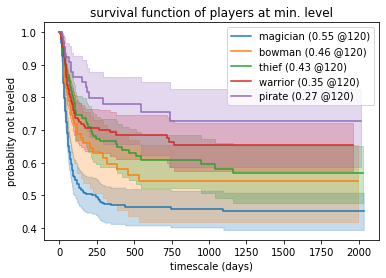

In [176]:
surv = []
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
jobs = ["magician", "bowman", "thief", "warrior", "pirate"]
for job in jobs:
    x = df[df.job == job]
    kmf.fit(x.duration, event_observed=x.observed)
    f120 = 1-kmf.survival_function_.KM_estimate.iloc[-1]
    kmf.plot_survival_function(ax=ax, label=f"{job} ({f120:.2f} @120)")
    surv.append(dict(job=job, 
                     surv=f120,
                     p90=kmf.percentile(0.90)))
    print(f"{job}: {kmf.percentile(0.9):.1f}")

plt.title("survival function of players at min. level")
plt.ylabel("probablity not leveled")
plt.xlabel("timescale (days)")

In [177]:
pd.options.display.float_format = "{:,.2f}".format
pd.DataFrame(frac).merge(pd.DataFrame(surv), on="job").sort_values("frac", ascending=False)

,job,n,frac,surv,p90
0,magician,330,0.52,0.55,23.80
1,bowman,75,0.43,0.46,33.47
2,thief,162,0.38,0.43,39.38
3,warrior,198,0.31,0.35,42.07
4,pirate,67,0.24,0.27,76.51


magician: 44.3
warrior: 101.8


Text(0.5, 0, 'timescale (days)')

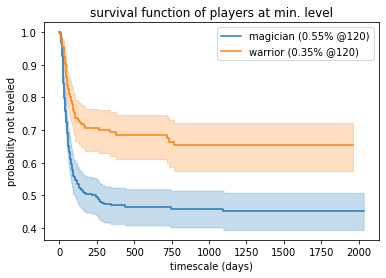

In [131]:
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
for job in ["magician", "warrior"]:
    x = df[df.job == job]
    kmf.fit(x.duration, event_observed=x.observed)
    kmf.plot_survival_function(ax=ax, label=f"{job} ({(1-kmf.survival_function_.KM_estimate.iloc[-1]):.2f}% @120)")
    print(f"{job}: {kmf.percentile(0.75):.1f}")

plt.title("survival function of players at min. level")
plt.ylabel("probablity not leveled")
plt.xlabel("timescale (days)")

magician: 44.3
bowman: 81.0


Text(0.5, 0, 'timescale (days)')

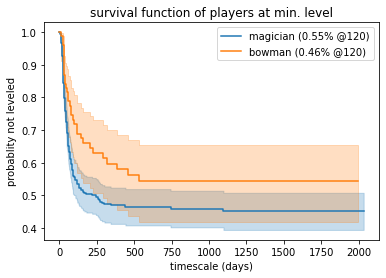

In [132]:
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
for job in ["magician", "bowman"]:
    x = df[df.job == job]
    kmf.fit(x.duration, event_observed=x.observed)
    kmf.plot_survival_function(ax=ax, label=f"{job} ({(1-kmf.survival_function_.KM_estimate.iloc[-1]):.2f}% @120)")
    print(f"{job}: {kmf.percentile(0.75):.1f}")

plt.title("survival function of players at min. level")
plt.ylabel("probablity not leveled")
plt.xlabel("timescale (days)")

In [137]:
from lifelines.statistics import logrank_test

mag = df[df.job == "magician"]
bow = df[df.job == "bowman"]

results = logrank_test(mag.duration, bow.duration, mag.observed, bow.observed, alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.84 0.05      4.32

In [134]:
mag = df[df.job == "magician"]
warrior = df[df.job == "warrior"]

results = logrank_test(mag.duration, warrior.duration, mag.observed, warrior.observed, alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          22.44 <0.005     18.81

In [135]:
mag = df[df.job == "magician"]
results = logrank_test(mag.duration, mag.duration, mag.observed, mag.observed, alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 1.00     -0.00